# Nuvem dos Candidatos

## Introdução

A ideia desse projeto é montar nuvens de palavras que realçam os termos mais frequentes nos planos de governo dos candidatos à presidência. Esse notebook irá demonstrar como fazer isso passo a passo.

## Dados Utilizados

Todos os planos foram baixados do [site oficial do TSE](http://divulgacandcontas.tse.jus.br/divulga/#/estados/2018/2022802018/BR/candidatos) e estão em formato PDF. Os arquivos originais estão na pasta `planos-de-governo`

## Desafios

Um arquivo PDF não contém apenas texto puro mas sim uma série de arquivos como imagens e dados de formatação que podem dificultar o processamento. Para a conversão desses arquivos, utilizei um serviço online de conversão da [lightPDF](https://lightpdf.com/pt/pdf-to-txt). Os arquivos convertidos usam a codificação CP1252 ao invés da UTF-8, para maior facilidade, converti todos para a codificação correta e os arquivos originados nessa etapa estão também na pasta `planos-de-governo` com o formato `nome_do_candidato.txt`. Esses serão os arquivos que darão base para a análise. Os arquivos de PDF são mantidos apenas como referência.

A conversão automática em PDF cria alguns problemas em si:

* Quebras de linha podem deixar o texto não legível
* Números de página, cabeçalhos e rodapé são todos inseridos no texto final
* Acentuações e símbolos podem ser mal processados
* Múltiplos espaços são adicionados

Adicionalmente, a geração de nuvens de palavras também tem seus desafios:

* Nem todas as palavras são significativas. Termos como "o", "a", "de", "ele", "ela", "porém" e etc devem ser cortados
* Números e símbolos não são relevantes
* Palavras escritas com maiúsculas e minúsculas devem ser contadas juntas

Obviamente, a escolha das listas de palavras que são significativas é subjetiva e altera o resultado final. A disponibilização integral do código e deste guia passo a passo torna mais fácil a modificação das listas de palavras que serão excluídas bem como de outros parâmetros da geração das nuvens.

## Limpando os Arquivos

A primeira parte do processo envolve carregar os arquivos de texto e limpá-los. As funções de limpeza estão no arquivo `limpeza.py`, vamos carregá-lo

In [1]:
import limpeza

Como podemos ver, `limpeza` possui diversos métodos prontos para utilizarmos:

In [3]:
help(limpeza)

Help on module limpeza:

NAME
    limpeza

DESCRIPTION
    encoding: utf-8
    A primeira parte do processamento.
    
    Os arquivos PDF convertidos automaticamente possuem diversas linhas em branco.
    Além disso, palavras muito curtas, preposições e pronomes não fazem sentido
    ao montar uma nuvem de palavras.
    
    Esse script passa por todos os arquivos de texto na pasta planos-de-governo e
    executa diversos procedimentos de limpeza, dando origem aos arquivos
    nome_do_candidato_limpo.txt, que serão utilizados nas próximas etapas.

FUNCTIONS
    converte_palavras_para_minúsculo(conteúdo_do_arquivo)
        Esta função retorna todas as linhas usando apenas letras minúsculas
    
    listdir(path=None)
        Return a list containing the names of the files in the directory.
        
        path can be specified as either str or bytes.  If path is bytes,
          the filenames returned will also be bytes; in all other circumstances
          the filenames returned will

E também define listas de palavras que serão excluídas, como as preposições da língua portuguesa:

In [4]:
limpeza.PREPOSIÇÕES

{'a',
 'ante',
 'após',
 'até',
 'com',
 'contra',
 'de',
 'desde',
 'em',
 'entre',
 'para',
 'perante',
 'por',
 'sem',
 'sob',
 'sobre',
 'trás'}

Vamos começar carregando o primeiro arquivo da lista, em ordem alfabética, a proposta do candidato Álvaro Dias:

In [6]:
proposta = open("planos-de-governo/alvaro_dias.txt").readlines()

Vamos observar as primeiras 10 linhas desse arquivo:

In [8]:
proposta[0:10]

['Coligação Mudança de Verdade\n',
 'Podemos, PSC, PRP, PTC Agosto de 2018\n',
 '\n',
 'Sumário\n',
 '\n',
 'Coligação Mudança de Verdade\n',
 '\n',
 'Objetivo\n',
 'Diretrizes Gerais\n',
 'Metas - SOCIEDADE\n']

E as 10 últimas:

In [10]:
proposta[-10:]

['7- Criar a carreira de Médico Federal para atender principalmente os municípios mais carentes do país;\n',
 '8- Tornar o FUNDEB permanente e priorizar a educação infantil e o ensino fundamental;\n',
 '9- Prorrogar, com bases em critérios técnicos, o prazo para o fim dos lixões e atuar concretamente para a formação de Consórcios Intermunicipais para melhor destinação correta dos resíduos sólidos;\n',
 '10- Aumentar o índice de prestação dos serviços de coleta de esgoto dos atuais 50% para 60% da população;\n',
 '11- Promover e incentivar a criação de Consórcios Intermunicipais de Saúde, de Infraestrutura e de Desenvolvimento Regional.\n',
 'Não permitirei que os cofres municipais continuem sendo surrupiados para financiar a ineficiência e a corrupção do Governo Federal.\n',
 'A refundação da República passa também por um novo pacto federativo.\n',
 'Alvaro Dias\n',
 '15\n',
 '\n']

Vamos inspecionar o total de linhas no arquivo:

In [11]:
len(proposta)

140

De início, removeremos linhas que possuem apenas espaços:

In [12]:
proposta = limpeza.remove_linhas_com_apenas_espaços(proposta)

In [13]:
len(proposta)

140

Como podemos ver, nesse caso nenhuma linha possuía exclusivamente espaços.

Vamos agora remover separadores de palavras como pontos, vírgulas e quebras de linha:

In [14]:
proposta = limpeza.remove_separadores_de_palavra(proposta)

Agora, inspecionamos novamente as primeiras 10 linhas e as 10 últimas:

In [15]:
proposta[0:10]

['Coligação Mudança de Verdade ',
 'Podemos, PSC, PRP, PTC Agosto de 2018 ',
 ' ',
 'Sumário ',
 ' ',
 'Coligação Mudança de Verdade ',
 ' ',
 'Objetivo ',
 'Diretrizes Gerais ',
 'Metas - SOCIEDADE ']

In [16]:
proposta[-10:]

['7- Criar a carreira de Médico Federal para atender principalmente os municípios mais carentes do país  ',
 '8- Tornar o FUNDEB permanente e priorizar a educação infantil e o ensino fundamental  ',
 '9- Prorrogar, com bases em critérios técnicos, o prazo para o fim dos lixões e atuar concretamente para a formação de Consórcios Intermunicipais para melhor destinação correta dos resíduos sólidos  ',
 '10- Aumentar o índice de prestação dos serviços de coleta de esgoto dos atuais 50% para 60% da população  ',
 '11- Promover e incentivar a criação de Consórcios Intermunicipais de Saúde, de Infraestrutura e de Desenvolvimento Regional  ',
 'Não permitirei que os cofres municipais continuem sendo surrupiados para financiar a ineficiência e a corrupção do Governo Federal  ',
 'A refundação da República passa também por um novo pacto federativo  ',
 'Alvaro Dias ',
 '15 ',
 ' ']

Observe que os pontos finais e quebras de linha foram removidos em relação à versão original e substituído por espaços. Vamos agora remover números, símbolos e tudo o que não for caracteres de texto:

In [17]:
proposta = limpeza.remove_tudo_o_que_não_for_letra(proposta)

Mais uma vez, verificamos o conteúdo das 10 primeiras e 10 últimas linhas:

In [18]:
proposta[0:10]

['Coligação Mudança de Verdade ',
 'Podemos  PSC  PRP  PTC Agosto de      ',
 ' ',
 'Sumário ',
 ' ',
 'Coligação Mudança de Verdade ',
 ' ',
 'Objetivo ',
 'Diretrizes Gerais ',
 'Metas   SOCIEDADE ']

In [19]:
proposta[-10:]

['   Criar a carreira de Médico Federal para atender principalmente os municípios mais carentes do país  ',
 '   Tornar o FUNDEB permanente e priorizar a educação infantil e o ensino fundamental  ',
 '   Prorrogar  com bases em critérios técnicos  o prazo para o fim dos lixões e atuar concretamente para a formação de Consórcios Intermunicipais para melhor destinação correta dos resíduos sólidos  ',
 '    Aumentar o índice de prestação dos serviços de coleta de esgoto dos atuais     para     da população  ',
 '    Promover e incentivar a criação de Consórcios Intermunicipais de Saúde  de Infraestrutura e de Desenvolvimento Regional  ',
 'Não permitirei que os cofres municipais continuem sendo surrupiados para financiar a ineficiência e a corrupção do Governo Federal  ',
 'A refundação da República passa também por um novo pacto federativo  ',
 'Alvaro Dias ',
 '   ',
 ' ']

Note que o número do candidato, índice das propostas e demais símbolos foram arrancados e trocados por espaços.
Vamos remover agora palavras pequenas. Por padrão, removeremos todas as palavras com 3 ou menos letras:

In [21]:
proposta = limpeza.remove_palavras_pequenas(proposta)

E vamos novamente inspecionar as 10 primeiras e 10 últimas linhas:

In [22]:
proposta[0:10]

['Coligação Mudança Verdade',
 'Podemos Agosto',
 '',
 'Sumário',
 '',
 'Coligação Mudança Verdade',
 '',
 'Objetivo',
 'Diretrizes Gerais',
 'Metas SOCIEDADE']

In [23]:
proposta[-10:]

['Criar carreira Médico Federal para atender principalmente municípios mais carentes país',
 'Tornar FUNDEB permanente priorizar educação infantil ensino fundamental',
 'Prorrogar bases critérios técnicos prazo para lixões atuar concretamente para formação Consórcios Intermunicipais para melhor destinação correta resíduos sólidos',
 'Aumentar índice prestação serviços coleta esgoto atuais para população',
 'Promover incentivar criação Consórcios Intermunicipais Saúde Infraestrutura Desenvolvimento Regional',
 'permitirei cofres municipais continuem sendo surrupiados para financiar ineficiência corrupção Governo Federal',
 'refundação República passa também novo pacto federativo',
 'Alvaro Dias',
 '',
 '']

Agora vamos normalizar todo o texto para lidarmos apenas com letras minúsculas:

In [25]:
proposta = limpeza.converte_palavras_para_minúsculo(proposta)

E observamos as mudanças:

In [26]:
proposta[0:10]

['coligação mudança verdade',
 'podemos agosto',
 '',
 'sumário',
 '',
 'coligação mudança verdade',
 '',
 'objetivo',
 'diretrizes gerais',
 'metas sociedade']

In [27]:
proposta[-10:]

['criar carreira médico federal para atender principalmente municípios mais carentes país',
 'tornar fundeb permanente priorizar educação infantil ensino fundamental',
 'prorrogar bases critérios técnicos prazo para lixões atuar concretamente para formação consórcios intermunicipais para melhor destinação correta resíduos sólidos',
 'aumentar índice prestação serviços coleta esgoto atuais para população',
 'promover incentivar criação consórcios intermunicipais saúde infraestrutura desenvolvimento regional',
 'permitirei cofres municipais continuem sendo surrupiados para financiar ineficiência corrupção governo federal',
 'refundação república passa também novo pacto federativo',
 'alvaro dias',
 '',
 '']

Agora, removemos as palavras indesejadas. Elas estão contida nas constantes `EXCLUIR`, `PREPOSIÇÕES` e `PRONOMES`. Você pode inspecionar o valor de cada uma delas da seguinte forma:

In [28]:
limpeza.PRONOMES

{'a',
 'algo',
 'algum',
 'alguma',
 'algumas',
 'alguns',
 'alguém',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'cada',
 'certa',
 'certas',
 'certo',
 'certos',
 'cuja',
 'cujas',
 'cujo',
 'cujos',
 'ela',
 'elas',
 'ele',
 'eles',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'estas',
 'este',
 'estes',
 'eu',
 'isso',
 'isto',
 'lhe',
 'lhes',
 'me',
 'meu',
 'meus',
 'mim',
 'minha',
 'minhas',
 'muita',
 'muitas',
 'muito',
 'muitos',
 'nada',
 'nenhum',
 'nenhuma',
 'nenhumas',
 'nenhuns',
 'ninguém',
 'nossa',
 'nossas',
 'nosso',
 'nossos',
 'nós',
 'o',
 'os',
 'outra',
 'outras',
 'outrem',
 'outro',
 'outros',
 'pouca',
 'poucas',
 'pouco',
 'poucos',
 'quais',
 'quaisquer',
 'qual',
 'qualquer',
 'quanta',
 'quantas',
 'quanto',
 'quantos',
 'se',
 'seu',
 'seus',
 'si',
 'sua',
 'suas',
 'sí',
 'tanta',
 'tantas',
 'tanto',
 'tantos',
 'te',
 'teu',
 'teus',
 'ti',
 'toda',
 'todas',
 'todo',
 'todos',
 'tu',
 'tua',
 'tuas',
 'tudo',
 'vos',
 'vo

Os três conjuntos de palavras serão removidos:

In [29]:
proposta = limpeza.remove_palavras_indesejadas(proposta)

E as mudanças são:

In [30]:
proposta[0:10]

['coligação mudança verdade',
 'podemos agosto',
 '',
 'sumário',
 '',
 'coligação mudança verdade',
 '',
 'objetivo',
 'diretrizes  ',
 'metas sociedade']

In [31]:
proposta[-10:]

['criar carreira médico federal   atender   municípios   carentes país',
 'tornar fundeb permanente priorizar educação infantil ensino fundamental',
 'prorrogar bases critérios técnicos prazo   lixões atuar concretamente   formação consórcios intermunicipais     destinação correta resíduos sólidos',
 '    prestação serviços coleta esgoto atuais   população',
 'promover incentivar criação consórcios intermunicipais saúde infraestrutura desenvolvimento regional',
 'permitirei cofres municipais continuem   surrupiados   financiar ineficiência corrupção governo federal',
 'refundação república passa   novo pacto federativo',
 'alvaro  ',
 '',
 '']

Veja como essas 10 últimas linhas são diferentes da versão original:

```python
['7- Criar a carreira de Médico Federal para atender principalmente os municípios mais carentes do país;\n',
 '8- Tornar o FUNDEB permanente e priorizar a educação infantil e o ensino fundamental;\n',
 '9- Prorrogar, com bases em critérios técnicos, o prazo para o fim dos lixões e atuar concretamente para a formação de Consórcios Intermunicipais para melhor destinação correta dos resíduos sólidos;\n',
 '10- Aumentar o índice de prestação dos serviços de coleta de esgoto dos atuais 50% para 60% da população;\n',
 '11- Promover e incentivar a criação de Consórcios Intermunicipais de Saúde, de Infraestrutura e de Desenvolvimento Regional.\n',
 'Não permitirei que os cofres municipais continuem sendo surrupiados para financiar a ineficiência e a corrupção do Governo Federal.\n',
 'A refundação da República passa também por um novo pacto federativo.\n',
 'Alvaro Dias\n',
 '15\n',
 '\n']
 ```

Como nós substituímos diversos caracteres e também por falhas na conversão de PDF para texto, muitas linhas possuem múltiplos espaços dentro dela. Vamos trocar os espaços múltiplos por um só:

In [33]:
proposta = limpeza.remove_espaços_múltiplos(proposta)

E o resultado é:

In [34]:
proposta[0:10]

['coligação mudança verdade',
 'podemos agosto',
 '',
 'sumário',
 '',
 'coligação mudança verdade',
 '',
 'objetivo',
 'diretrizes ',
 'metas sociedade']

In [35]:
proposta[-10:]

['criar carreira médico federal atender municípios carentes país',
 'tornar fundeb permanente priorizar educação infantil ensino fundamental',
 'prorrogar bases critérios técnicos prazo lixões atuar concretamente formação consórcios intermunicipais destinação correta resíduos sólidos',
 ' prestação serviços coleta esgoto atuais população',
 'promover incentivar criação consórcios intermunicipais saúde infraestrutura desenvolvimento regional',
 'permitirei cofres municipais continuem surrupiados financiar ineficiência corrupção governo federal',
 'refundação república passa novo pacto federativo',
 'alvaro ',
 '',
 '']

Por fim, removemos as linhas com apenas espaços mais uma vez:

In [36]:
proposta = limpeza.remove_linhas_com_apenas_espaços(proposta)

In [37]:
proposta[0:10]

['coligação mudança verdade',
 'podemos agosto',
 'sumário',
 'coligação mudança verdade',
 'objetivo',
 'diretrizes ',
 'metas sociedade',
 'emprego segurança tolerância zero saúde pronto atendimento ciência cultura turismo educação futuro família unida verde água saneamento',
 'metas economia',
 'estrutura fiscal eficiente impostos capital previdência social crédito vexame indústria planeta agro infraestrutura século diplomacia comércio']

In [39]:
proposta[-10:]

['garantir apoio técnico órgãos federais melhorar gestão administrativa orientar fluxo recursos prestação contas',
 'promover reforma tributária estabeleça prioridade justa distribuição recursos entes federados contexto novo pacto federativo',
 'criar carreira médico federal atender municípios carentes país',
 'tornar fundeb permanente priorizar educação infantil ensino fundamental',
 'prorrogar bases critérios técnicos prazo lixões atuar concretamente formação consórcios intermunicipais destinação correta resíduos sólidos',
 ' prestação serviços coleta esgoto atuais população',
 'promover incentivar criação consórcios intermunicipais saúde infraestrutura desenvolvimento regional',
 'permitirei cofres municipais continuem surrupiados financiar ineficiência corrupção governo federal',
 'refundação república passa novo pacto federativo',
 'alvaro ']

## Contando Palavras

Além de gerar nuvens, podemos facilmente contar a frequência de palavras utilizando da classe `Counter`, do módulo `collections`. [Documentação](https://docs.python.org/3/library/collections.html#collections.Counter)

Como `proposta` armazena uma lista de todas as linhas do arquivo, iremos construir uma lista com todas as palavras:

In [44]:
from collections import Counter

palavras = []  # Lista vazia para guardar as palavras

for linha in proposta:  # Percorrendo todas as linhas da proposta
    # A função split quebra a linha ao redor dos espaços e o método
    # extend insere as palavras na lista
    palavras.extend(linha.split())
    
print(palavras[0:10])

['coligação', 'mudança', 'verdade', 'podemos', 'agosto', 'sumário', 'coligação', 'mudança', 'verdade', 'objetivo']


O comportamento da função `split` é de quebrar as palavras separadas por espaço, por exemplo:

In [45]:
brasil = "República Federativa do Brasil"

In [46]:
brasil.split()

['República', 'Federativa', 'do', 'Brasil']

Portanto o que temos na lista `palavras` é exatamente uma lista com todas as palavras da proposta limpa. Podemos agora criar um `Counter` com ela:

In [47]:
frequência_de_palavras = Counter(palavras)

In [55]:
frequência_de_palavras

Counter({'coligação': 19,
         'mudança': 20,
         'verdade': 19,
         'podemos': 2,
         'agosto': 1,
         'sumário': 1,
         'objetivo': 5,
         'diretrizes': 5,
         'metas': 13,
         'sociedade': 9,
         'emprego': 5,
         'segurança': 5,
         'tolerância': 3,
         'zero': 5,
         'saúde': 7,
         'pronto': 2,
         'atendimento': 2,
         'ciência': 2,
         'cultura': 2,
         'turismo': 2,
         'educação': 8,
         'futuro': 4,
         'família': 2,
         'unida': 2,
         'verde': 2,
         'água': 2,
         'saneamento': 2,
         'economia': 7,
         'estrutura': 2,
         'fiscal': 1,
         'eficiente': 4,
         'impostos': 2,
         'capital': 4,
         'previdência': 2,
         'social': 8,
         'crédito': 1,
         'vexame': 1,
         'indústria': 5,
         'planeta': 1,
         'agro': 1,
         'infraestrutura': 7,
         'século': 2,
         'dipl

Observe que a palavra "coligação" aparece com uma frequência alta. Suponha que a gente queira adicioná-la na lista de exclusão e executar todo o processo novamente mas sem ela.

Primeiro vamos criar uma função que recebe o nome do arquivo, carrega na memória e executa para nós todos os passos que fizemos manualmente:

In [49]:
def limpa_arquivo(nome_do_arquivo):
    proposta = open(nome_do_arquivo).readlines()  # Lê o arquivo
    proposta = limpeza.remove_linhas_com_apenas_espaços(proposta)
    proposta = limpeza.remove_separadores_de_palavra(proposta)
    proposta = limpeza.remove_tudo_o_que_não_for_letra(proposta)
    proposta = limpeza.remove_palavras_pequenas(proposta)
    proposta = limpeza.converte_palavras_para_minúsculo(proposta)
    proposta = limpeza.remove_palavras_indesejadas(proposta)
    proposta = limpeza.remove_espaços_múltiplos(proposta)
    proposta = limpeza.remove_linhas_com_apenas_espaços(proposta)
    
    return proposta

E vamos também criar uma função que faz o trabalho de contar a frequência das palavras:

In [50]:
def conta_frequência_de_palavras(conteúdo):
    palavras = []  # Lista vazia para guardar as palavras

    for linha in conteúdo:  # Percorrendo todas as linhas
        # Insere as palavras na lista
        palavras.extend(linha.split())
        
    frequência_de_palavras = Counter(palavras)
    
    return frequência_de_palavras
    

Pronto! Agora temos duas funções que resumem tudo o que fizemos até agora. Vamos modificar o conjunto de palavras `EXCLUIR` para adicionar a palavra `coligação`:

In [51]:
limpeza.EXCLUIR.add('coligação')

Vamos carregar novamente o arquivo e executar todas as etapas de limpeza:

In [52]:
proposta = limpa_arquivo('planos-de-governo/alvaro_dias.txt')

E vamos contar as palavras:

In [53]:
frequência = conta_frequência_de_palavras(proposta)

O resultado agora é:

In [54]:
frequência

Counter({'mudança': 20,
         'verdade': 19,
         'podemos': 2,
         'agosto': 1,
         'sumário': 1,
         'objetivo': 5,
         'diretrizes': 5,
         'metas': 13,
         'sociedade': 9,
         'emprego': 5,
         'segurança': 5,
         'tolerância': 3,
         'zero': 5,
         'saúde': 7,
         'pronto': 2,
         'atendimento': 2,
         'ciência': 2,
         'cultura': 2,
         'turismo': 2,
         'educação': 8,
         'futuro': 4,
         'família': 2,
         'unida': 2,
         'verde': 2,
         'água': 2,
         'saneamento': 2,
         'economia': 7,
         'estrutura': 2,
         'fiscal': 1,
         'eficiente': 4,
         'impostos': 2,
         'capital': 4,
         'previdência': 2,
         'social': 8,
         'crédito': 1,
         'vexame': 1,
         'indústria': 5,
         'planeta': 1,
         'agro': 1,
         'infraestrutura': 7,
         'século': 2,
         'diplomacia': 2,
         'comé

Observe que coligação não está nele:

In [56]:
'coligação' in frequência

False

Mas `mudança`, por exemplo, está:

In [57]:
'mudança' in frequência

True

Podemos facilmente ver a frequência de uma palavra arbitrária:

In [58]:
frequência['brasil']

7

In [59]:
frequência['mudança']

20

## Montando Nuvens

Como já temos um texto processado e até mesmo as frequências contadas, podemos montar uma nuvem de palavras diretamente das frequências:

In [61]:
from wordcloud import WordCloud, ImageColorGenerator

A biblioteca `wordcloud` oferece ferramentas poderosas para construir as nuvens. Sua documentação completa pode ser vista [aqui](http://amueller.github.io/word_cloud/index.html).

Vamos começar criando uma nuvem simples, de 500px altura por 500px de largura e considerando apenas as 20 palavras mais frequentes:

In [66]:
gerador_nuvem = WordCloud(width=700, height=500, max_words=20)

Na versão original do script de montagem, as nuvens são feitas com base em arquivos salvos no disco. Como já temos as frequências contadas em memória, podemos utilizar diretamente delas:

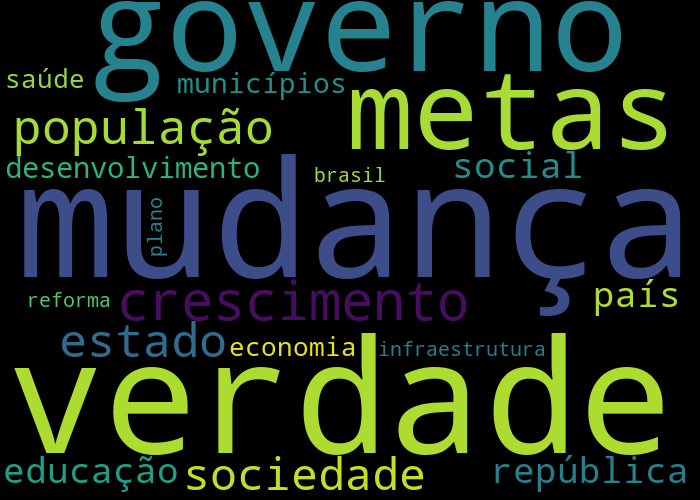

In [67]:
gerador_nuvem.generate_from_frequencies(frequência).to_image()

Podemos também encapsular o processo de geração da nuvem em uma função:

In [75]:
def gera_nuvem_de_frequências(frequência, altura=500, largura=700, número_de_palavras=20):
    gerador_nuvem = WordCloud(height=altura, width=largura, max_words=número_de_palavras)
    return gerador_nuvem.generate_from_frequencies(frequência).to_image()

Essa função não faz nada mais do que o que nós fizemos nas últimas duas etapas, mas agora podemos alterar os parâmetros de forma mais fácil:

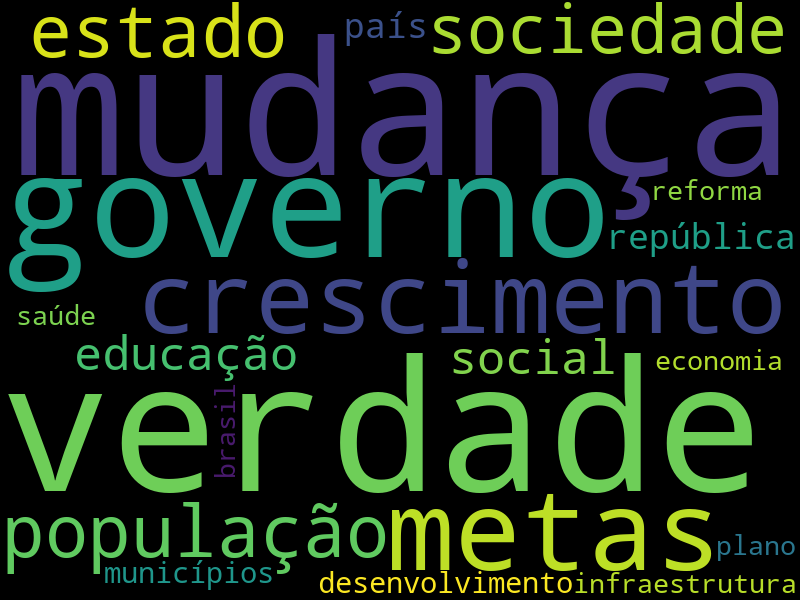

In [76]:
gera_nuvem_de_frequências(frequência, altura=600, largura=800)

Podemos também juntar todas as três funções que criamos até agora e criar uma nova função que cria uma nuvem de palavras direto de um arquivo de texto:

In [79]:
def gera_nuvem(nome_do_arquivo, altura=500, largura=700, número_de_palavras=20):
    proposta = limpa_arquivo(nome_do_arquivo)  # Nossa primeira função, que executa toda a limpeza
    
    frequência = conta_frequência_de_palavras(proposta)  # A segunda função, para contagem de frequência
    
    # A última função que monta as nuvens
    return gera_nuvem_de_frequências(frequência, altura=altura,
                                     largura=largura, número_de_palavras=número_de_palavras)

Agora é possível montar facilmente nuvens com base em qualquer arquivo:

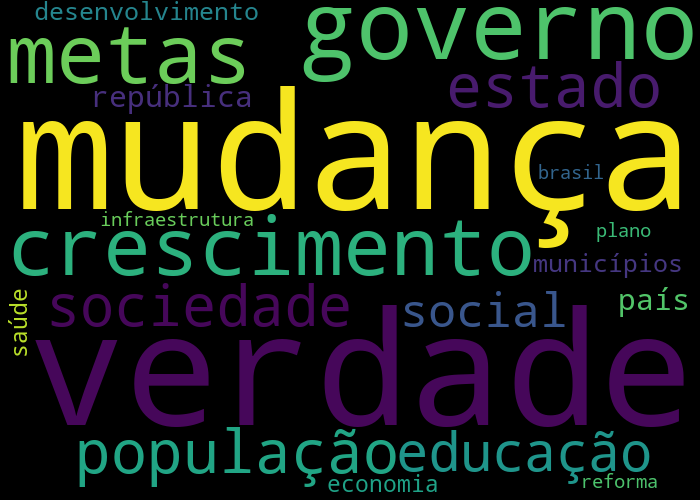

In [80]:
gera_nuvem('planos-de-governo/alvaro_dias.txt')

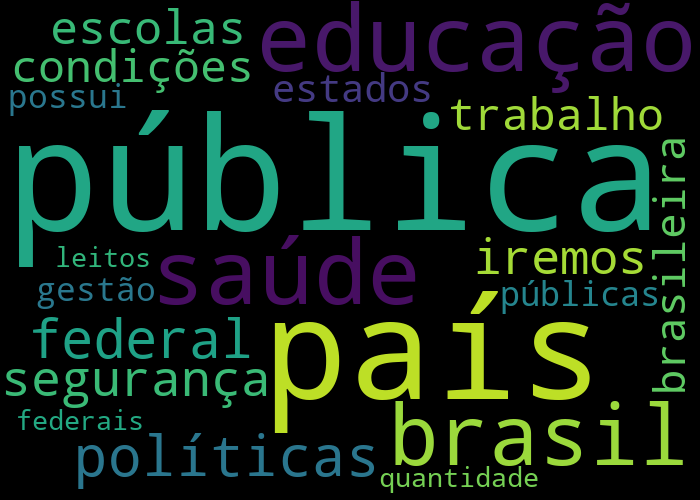

In [81]:
gera_nuvem('planos-de-governo/cabo_daciolo.txt')

Observe que nesses dois últimos exemplos, eu não especifiquei `altura`, `largura` e `número_de_palavras` isso acontece porque eu defini a função dessa forma:

```python
def gera_nuvem(nome_do_arquivo, altura=500, largura=700, número_de_palavras=20)
```

o que faz com que os três argumentos sejam opcionais e tenha o valor padrão de 500, 700 e 20, respectivamente. Qualquer um dos argumentos pode ser customizado utilizando seu nome:

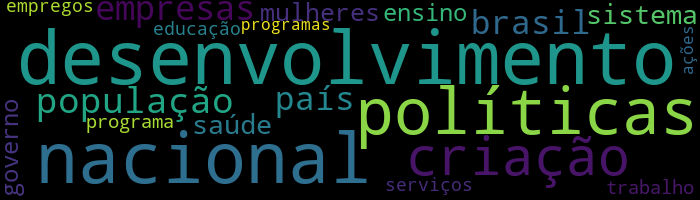

In [83]:
gera_nuvem('planos-de-governo/ciro_gomes.txt', altura=200)

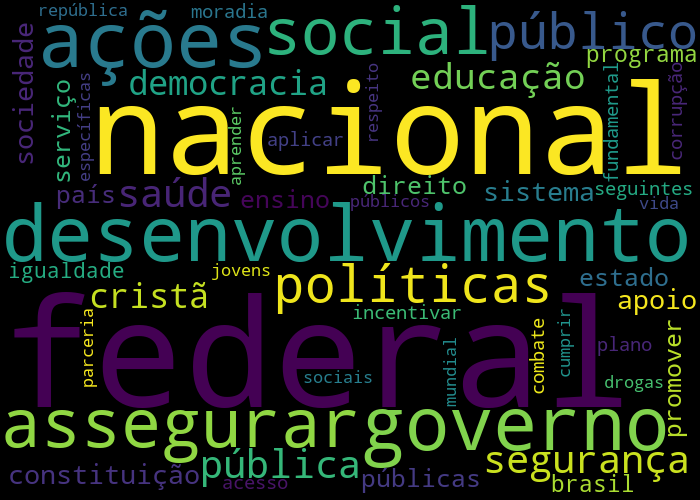

In [85]:
gera_nuvem('planos-de-governo/eymael.txt', número_de_palavras=50)

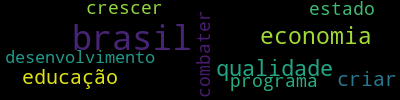

In [86]:
gera_nuvem('planos-de-governo/geraldo_alckmin.txt', largura=400, altura=100, número_de_palavras=10)

E assim sucessivamente. É possível também fazer um loop por todos os arquivos de texto e gerar as nuvens em massa:

alvaro_dias.txt


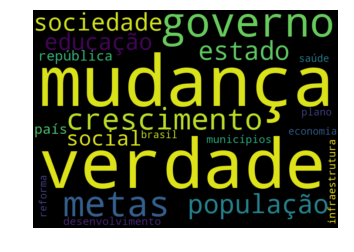

luiz_inacio_lula_da_silva.txt


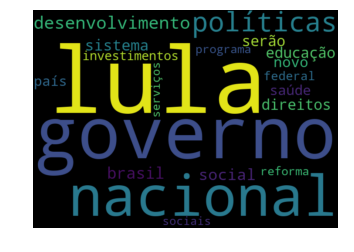

joao_amoedo.txt


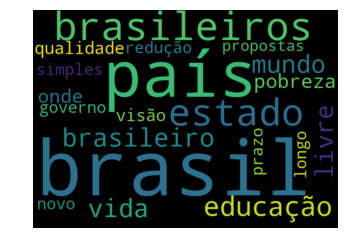

ciro_gomes.txt


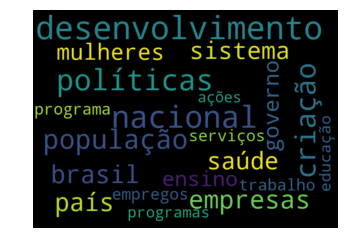

marina_silva.txt


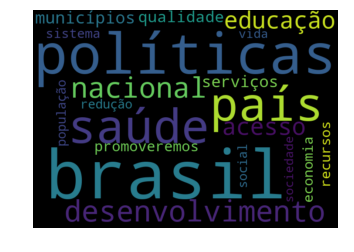

eymael.txt


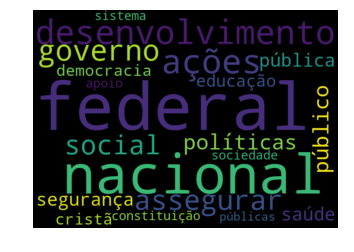

guilherme_boulos.txt


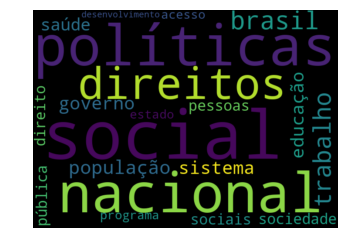

cabo_daciolo.txt


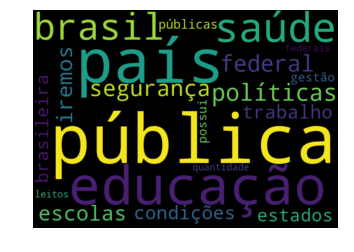

vera.txt


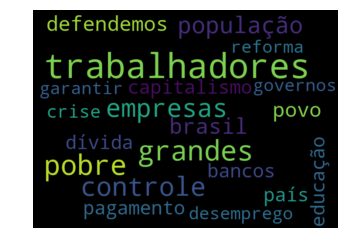

jair_bolsonaro.txt


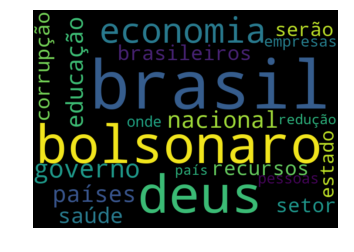

joao_goulart_filho.txt


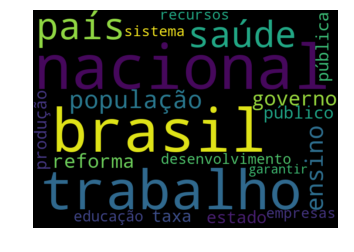

geraldo_alckmin.txt


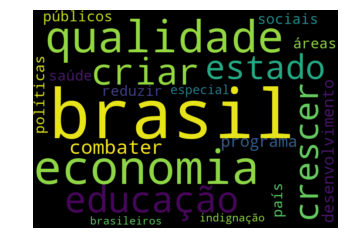

henrique_meireles.txt


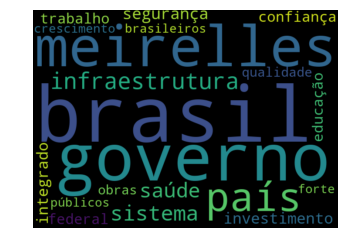

In [95]:
from os import listdir  # Função que retorna todo o conteúdo do diretório
from os.path import join  # Função que vai montar um nome de arquivo com o nome da pasta junto
import matplotlib.pyplot as plt  # Precisaremos dessa função para exibir as imagens dentro de um loop

for arquivo in listdir('planos-de-governo'):  # Percorrendo todos os arquivos
    
    # Vamos processar só os arquivos que terminam em txt mas que não são
    # os arquivos já limpos que podem estar salvos
    if arquivo.endswith('.txt') and not arquivo.endswith('_limpo.txt'):
        print(arquivo)  # Imprime o nome do arquivo sendo processado
        nome_do_arquivo = join('planos-de-governo', arquivo)  # Monta o nome do arquivo completo
        plt.axis("off")  # Cria um gráfico sem os eixos x e y
        plt.imshow(gera_nuvem(nome_do_arquivo), interpolation="bilinear")  # Carrega a nuvem
        plt.show()  # Exibe no notebook
        

Podemos mais uma vez guardar nosso trabalho numa função que gera todas as imagens:

In [99]:
def gera_todas_as_nuvens(altura=500, largura=700, número_de_palavras=20):
    for arquivo in listdir('planos-de-governo'):  # Percorrendo todos os arquivos
    
        # Vamos processar só os arquivos que terminam em txt mas que não são
        # os arquivos já limpos que podem estar salvos
        if arquivo.endswith('.txt') and not arquivo.endswith('_limpo.txt'):
            print(arquivo)  # Imprime o nome do arquivo sendo processado
            nome_do_arquivo = join('planos-de-governo', arquivo)  # Monta o nome do arquivo completo
            nuvem = gera_nuvem(nome_do_arquivo, altura=altura, largura=largura,
                       número_de_palavras=número_de_palavras)  # Cria a nuvem
            plt.axis("off")  # Cria um gráfico sem os eixos x e y
            plt.imshow(nuvem, interpolation="bilinear")  # Carrega a nuvem
            plt.show()  # Exibe no notebook

Agora é possível gerar nuvens em massa com parâmetros customizados:

alvaro_dias.txt


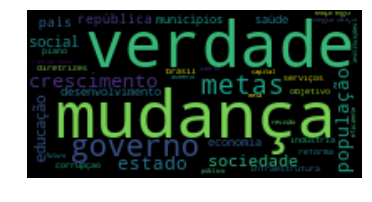

luiz_inacio_lula_da_silva.txt


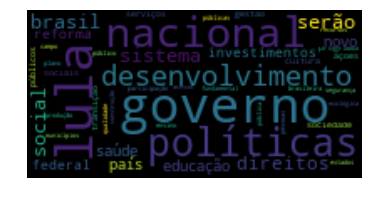

joao_amoedo.txt


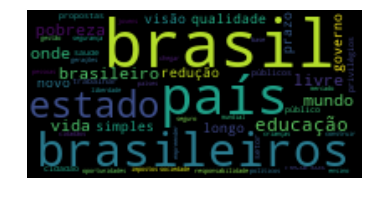

ciro_gomes.txt


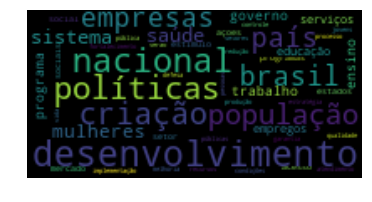

marina_silva.txt


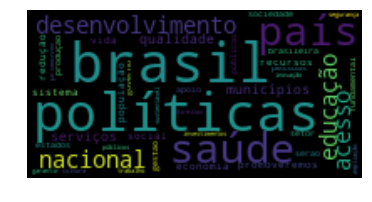

eymael.txt


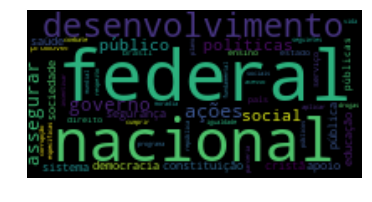

guilherme_boulos.txt


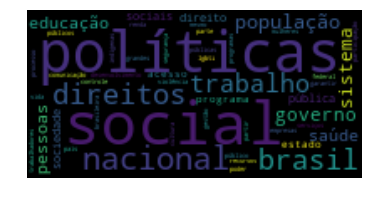

cabo_daciolo.txt


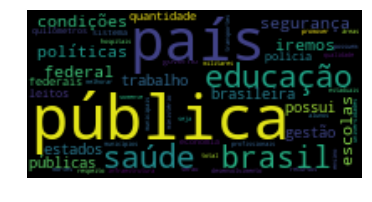

vera.txt


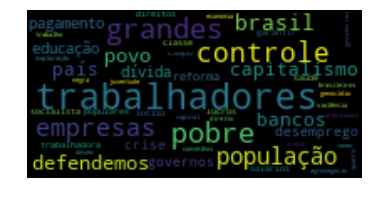

jair_bolsonaro.txt


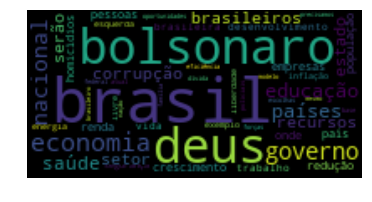

joao_goulart_filho.txt


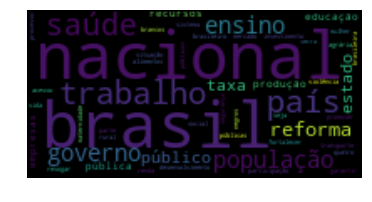

geraldo_alckmin.txt


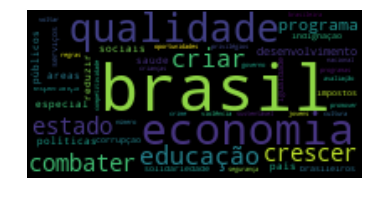

henrique_meireles.txt


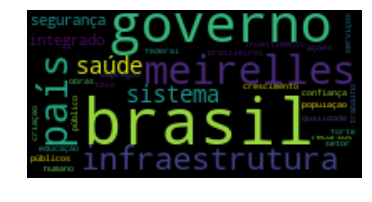

In [100]:
gera_todas_as_nuvens(altura=100, largura=200, número_de_palavras=50)

Assim como é possível customizar a lista de exclusão e rodar tudo de novo:

In [101]:
limpeza.EXCLUIR.add('brasil')  # Excluindo o termo brasil

alvaro_dias.txt


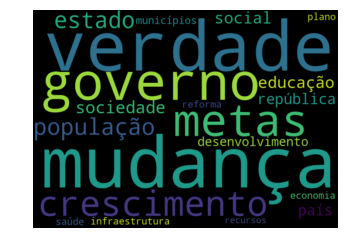

luiz_inacio_lula_da_silva.txt


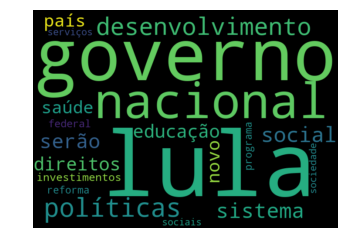

joao_amoedo.txt


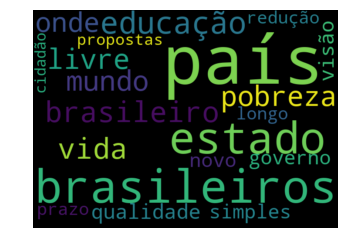

ciro_gomes.txt


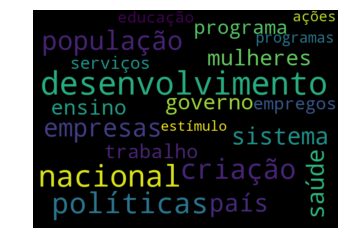

marina_silva.txt


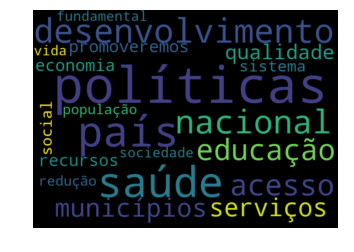

eymael.txt


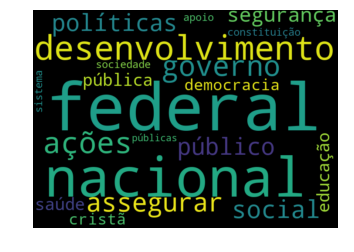

guilherme_boulos.txt


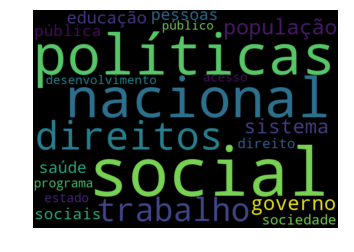

cabo_daciolo.txt


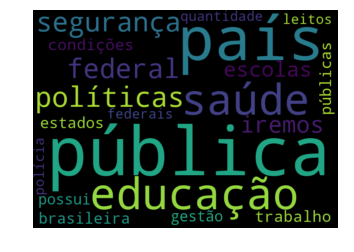

vera.txt


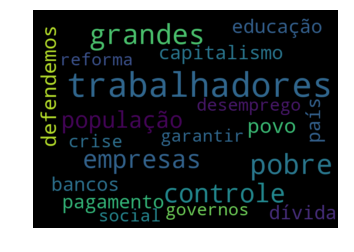

jair_bolsonaro.txt


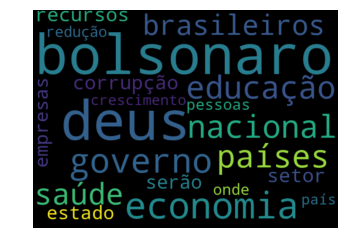

joao_goulart_filho.txt


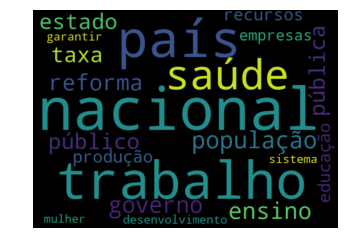

geraldo_alckmin.txt


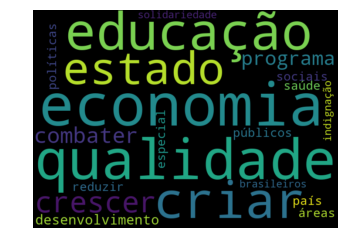

henrique_meireles.txt


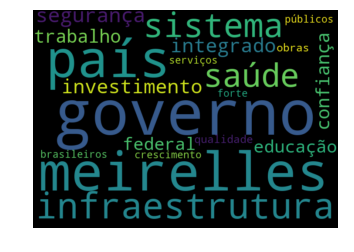

In [102]:
gera_todas_as_nuvens()

__Divirtam-se! Briquem com o código, gerem suas nuvens com seus parâmetros, colabore, distribua pros amigos. Esse código é livre.__